In [42]:
library(renv)
library(glmnet)
library(tidyverse)
library(caret)
library(rstan)
library(bayesplot)

In [43]:
data <- read_csv("../Data/gameData.csv")
head(data)

New names:
• `` -> `...1`
Rows: 70 Columns: 130
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (13): ...1, championName, individualPosition, lane, missions, perks, pu...
dbl (108): allInPings, assistMePings, assists, baronKills, basicPings, bount...
lgl   (9): eligibleForProgression, firstBloodAssist, firstBloodKill, firstTo...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


...1,allInPings,assistMePings,assists,baronKills,basicPings,bountyLevel,champExperience,champLevel,championId,⋯,turretKills,turretTakedowns,turretsLost,unrealKills,visionClearedPings,visionScore,visionWardsBoughtInGame,wardsKilled,wardsPlaced,win
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>
NA1_4926006174,0,0,9,0,0,0,11799,14,777,⋯,1,1,1,0,0,15,0,1,6,TRUE
NA1_4925975967,4,2,6,0,0,1,19365,18,777,⋯,1,3,4,0,0,24,1,0,12,TRUE
NA1_4925949849,1,0,4,0,0,2,11829,14,84,⋯,0,1,2,0,0,12,0,1,6,TRUE
NA1_4925113905,0,0,5,0,0,1,14975,16,777,⋯,1,2,1,0,0,20,0,4,8,TRUE
NA1_4925061795,0,0,4,0,0,0,12950,14,61,⋯,1,2,11,0,0,12,1,2,6,FALSE
NA1_4925026917,2,4,7,0,0,0,12155,14,61,⋯,1,2,8,0,0,18,1,2,8,FALSE


In [ ]:
droppedColumns <- c()
for (i in 1:length(colnames(select_if(data, is.numeric)))){
    column <- toString(colnames(select_if(data, is.numeric))[i])
    if (sum(data[column]) == 0){
        droppedColumns <- c(droppedColumns, column)
    }
}

data <- data %>% select(-c(puuid, summonerName, riotIdGameName, riotIdTagline, summonerId, objectivesStolen, profileIcon, summoner1Id, nexusLost, nexusTakedowns))
data <- data[, !colnames(data) %in% droppedColumns]

data$win <- as.numeric(data$win)

data_numeric <- data %>% select(where(is.numeric))

data_numeric <- na.omit(data_numeric)

X <- data_numeric %>% select(-win) %>% as.matrix()
y <- data_numeric$win



In [ ]:
set.seed(123)
train_index <- createDataPartition(y, p = 0.7, list = FALSE)
X_train <- X[train_index, ]
y_train <- y[train_index]
X_test <- X[-train_index, ]
y_test <- y[-train_index]



In [ ]:
X_train_scaled <- scale(X_train)
X_test_scaled <- scale(X_test, center = attr(X_train_scaled, "scaled:center"), scale = attr(X_train_scaled, "scaled:scale"))

cvfit <- cv.glmnet(X_train_scaled, y_train, family = "binomial", alpha = 1, type.measure = "class")



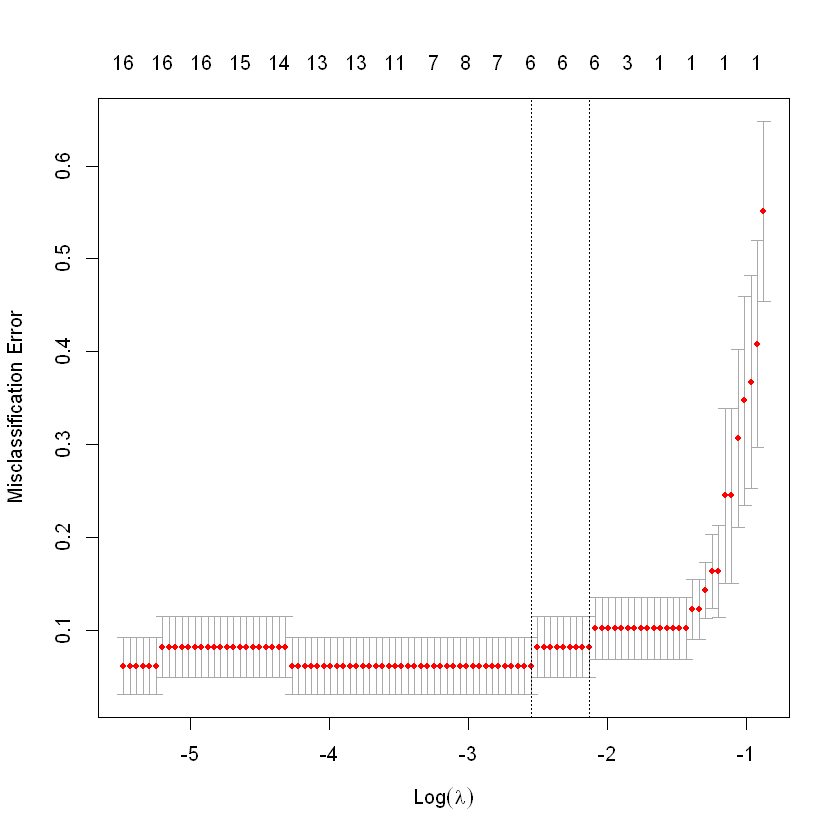

In [47]:
plot(cvfit)

In [ ]:
# Best lambda
best_lambda <- cvfit$lambda.min

lasso_coef <- coef(cvfit, s = "lambda.min")
selected_features <- rownames(lasso_coef)[lasso_coef[, 1] != 0]
selected_features <- selected_features[selected_features != "(Intercept)"]
print(selected_features)

pred_probs <- predict(cvfit, newx = X_test_scaled, s = "lambda.min", type = "response")
pred_class <- ifelse(pred_probs > 0.5, 1, 0)

confusionMatrix(factor(pred_class), factor(y_test))

[1] "assists"             "inhibitorTakedowns"  "kills"              
[4] "largestKillingSpree" "turretTakedowns"     "turretsLost"        


Confusion Matrix and Statistics

          Reference
Prediction  0  1
         0 11  0
         1  0 10
                                     
               Accuracy : 1          
                 95% CI : (0.8389, 1)
    No Information Rate : 0.5238     
    P-Value [Acc > NIR] : 1.267e-06  
                                     
                  Kappa : 1          
                                     
 Mcnemar's Test P-Value : NA         
                                     
            Sensitivity : 1.0000     
            Specificity : 1.0000     
         Pos Pred Value : 1.0000     
         Neg Pred Value : 1.0000     
             Prevalence : 0.5238     
         Detection Rate : 0.5238     
   Detection Prevalence : 0.5238     
      Balanced Accuracy : 1.0000     
                                     
       'Positive' Class : 0          
                                     

In [ ]:

n_test <- nrow(X_test_scaled)

k <- sum(lasso_coef[-1, 1] != 0)

pred_probs <- predict(cvfit, newx = X_test_scaled, s = "lambda.min", type = "response")

pred_probs <- pmin(pmax(pred_probs, 1e-15), 1 - 1e-15)

log_likelihood <- sum(y_test * log(pred_probs) + (1 - y_test) * log(1 - pred_probs))

bic <- -2 * log_likelihood + k * log(n_test)
cat("BIC of the LASSO logistic regression model:", bic, "\n")


BIC of the LASSO logistic regression model: 25.81679 


In [ ]:

X <- data %>% select(all_of(selected_features)) %>% as.matrix()
y <- data$win

set.seed(123)
train_index <- createDataPartition(y, p = 0.7, list = FALSE)
X_train <- X[train_index, ]
y_train <- y[train_index]
X_test <- X[-train_index, ]
y_test <- y[-train_index]

X_train_scaled <- scale(X_train)
X_test_scaled <- scale(X_test, center = attr(X_train_scaled, "scaled:center"),
                                  scale = attr(X_train_scaled, "scaled:scale"))

stan_data <- list(
  N = nrow(X_train_scaled),
  K = ncol(X_train_scaled),
  X = X_train_scaled,
  y = y_train
)



In [51]:
# Fit model
fit <- stan(file = "bayes_logistic.stan", data = stan_data,
            iter = 2000, chains = 4, seed = 123)

# Print results
print(fit, pars = c("beta"))




SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 7.4e-05 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0.74 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 2000 [  0%]  (Warmup)
Chain 1: Iteration:  200 / 2000 [ 10%]  (Warmup)
Chain 1: Iteration:  400 / 2000 [ 20%]  (Warmup)
Chain 1: Iteration:  600 / 2000 [ 30%]  (Warmup)
Chain 1: Iteration:  800 / 2000 [ 40%]  (Warmup)
Chain 1: Iteration: 1000 / 2000 [ 50%]  (Warmup)
Chain 1: Iteration: 1001 / 2000 [ 50%]  (Sampling)
Chain 1: Iteration: 1200 / 2000 [ 60%]  (Sampling)
Chain 1: Iteration: 1400 / 2000 [ 70%]  (Sampling)
Chain 1: Iteration: 1600 / 2000 [ 80%]  (Sampling)
Chain 1: Iteration: 1800 / 2000 [ 90%]  (Sampling)
Chain 1: Iteration: 2000 / 2000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 0.027 seconds (Warm-up)
Chain 1:                0.026 seconds (Sampling)
Chain 1:                0.05

In [ ]:
posterior <- extract(fit)
beta_post <- posterior$beta

pred_probs <- plogis(X_test_scaled %*% t(beta_post))
mean_pred_probs <- rowMeans(pred_probs)
y_pred <- ifelse(mean_pred_probs > 0.5, 1, 0)

confusionMatrix(factor(y_pred), factor(y_test))



Confusion Matrix and Statistics

          Reference
Prediction  0  1
         0 11  0
         1  0 10
                                     
               Accuracy : 1          
                 95% CI : (0.8389, 1)
    No Information Rate : 0.5238     
    P-Value [Acc > NIR] : 1.267e-06  
                                     
                  Kappa : 1          
                                     
 Mcnemar's Test P-Value : NA         
                                     
            Sensitivity : 1.0000     
            Specificity : 1.0000     
         Pos Pred Value : 1.0000     
         Neg Pred Value : 1.0000     
             Prevalence : 0.5238     
         Detection Rate : 0.5238     
   Detection Prevalence : 0.5238     
      Balanced Accuracy : 1.0000     
                                     
       'Positive' Class : 0          
                                     

In [53]:

beta_mean <- colMeans(beta_post)

mean_pred_probs <- plogis(X_test_scaled %*% beta_mean)

mean_pred_probs <- pmin(pmax(mean_pred_probs, 1e-15), 1 - 1e-15)

# Compute log-likelihood
log_lik <- sum(ifelse(y_test == 1, log(mean_pred_probs), log(1 - mean_pred_probs)))

# Compute BIC
k <- length(beta_mean)  # number of coefficients
n <- length(y_test)
bic <- -2 * log_lik + k * log(n)

cat("Correct BIC (using posterior mean):", bic, "\n")


Correct BIC (using posterior mean): 22.98501 
